In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt  
from model.create_dataset import esm_alphabet, convert  
from model.affinity_pred_model import AffinityPredictor
from model.utilities import get_model 
import random 
import torch  

## Load Ab-Affinity, and ESM-2 model, get the embeddings for test antibody sequences

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = get_model() 
model.to(device)

AffinityPredictor(
  (encoder): ESM2(
    (embed_tokens): Embedding(33, 1280, padding_idx=1)
    (layers): ModuleList(
      (0-32): 33 x TransformerLayer(
        (self_attn): MultiheadAttention(
          (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
          (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
          (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
          (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
          (rot_emb): RotaryEmbedding()
        )
        (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (fc1): Linear(in_features=1280, out_features=5120, bias=True)
        (fc2): Linear(in_features=5120, out_features=1280, bias=True)
        (final_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      )
    )
    (contact_head): ContactPredictionHead(
      (regression): Linear(in_features=660, out_features=1, bias=True)
      (activat

In [ ]:
df = pd.read_csv('data/test_data_with_labels.csv') 

In [ ]:
inputs = df['Sequence'].tolist()  
outputs_list = []
with torch.no_grad():
    for i in range(0, len(inputs)):
        seq = torch.unsqueeze(torch.tensor(convert(inputs[i])),0).to(device) 
        outputs_batch =  model.encoder(seq, repr_layers=[33], return_contacts=True) 
        outputs_list.append(torch.mean(outputs_batch['representations'][33], dim=1).to('cpu')) 
        print(i+1, end = ", ", flush=True) 
        del seq, outputs_batch  
        torch.cuda.empty_cache() 
outputs_list = torch.cat(outputs_list).numpy() 
print(outputs_list.shape)

In [6]:
import h5py 
with h5py.File('embeddings/embeddings_test_data.h5', 'w') as f:
    f.create_dataset('embeddings_test_data', data=outputs_list) 

In [13]:
import esm 
model2 , _ = esm.pretrained.esm2_t33_650M_UR50D()
model2.to(device)

ESM2(
  (embed_tokens): Embedding(33, 1280, padding_idx=1)
  (layers): ModuleList(
    (0-32): 33 x TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (rot_emb): RotaryEmbedding()
      )
      (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=1280, out_features=5120, bias=True)
      (fc2): Linear(in_features=5120, out_features=1280, bias=True)
      (final_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    )
  )
  (contact_head): ContactPredictionHead(
    (regression): Linear(in_features=660, out_features=1, bias=True)
    (activation): Sigmoid()
  )
  (emb_layer_norm_after): LayerNorm((1280,), eps=1

In [ ]:
inputs = df['Sequence'].tolist()  
outputs_list2 = []
with torch.no_grad():
    for i in range(0, len(inputs)):
        seq = torch.unsqueeze(torch.tensor(convert(inputs[i])),0).to(device) 
        outputs_batch =  model2(seq, repr_layers=[33], return_contacts=True) 
        outputs_list2.append(torch.mean(outputs_batch['representations'][33], dim=1).to('cpu')) 
        #print(i+1, end = ", ", flush=True) 
        del seq, outputs_batch  
        torch.cuda.empty_cache() 
outputs_list2 = torch.cat(outputs_list2).numpy() 
#print(outputs_list2.shape)

import h5py 
with h5py.File('embeddings/esm_emb_test_data.h5', 'w') as f:
    f.create_dataset('esm_emb_test_data', data=outputs_list2) 
    

In [7]:
import h5py 
with h5py.File('embeddings/esm_emb_test_data.h5', 'r') as f:
    esm_emb = f['esm_emb_test_data'][:]
    
with h5py.File('embeddings/embeddings_test_data.h5', 'r') as f:
    model_emb = f['embeddings_test_data'][:]

print(esm_emb.shape, model_emb.shape )

(11670, 1280) (11670, 1280)


## Affinity Class Prediction 

In [ ]:
test_data_labels = df['affinity_class'].tolist() 

#### ESM-2

/home/fashr003/anaconda3/envs/fbagpuenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           1     0.6667    0.0075    0.0148       535
           2     0.6529    0.8825    0.7505      2340
           3     0.5271    0.3685    0.4337       977

    accuracy                         0.6306      3852
   macro avg     0.6155    0.4195    0.3997      3852
weighted avg     0.6229    0.6306    0.5680      3852



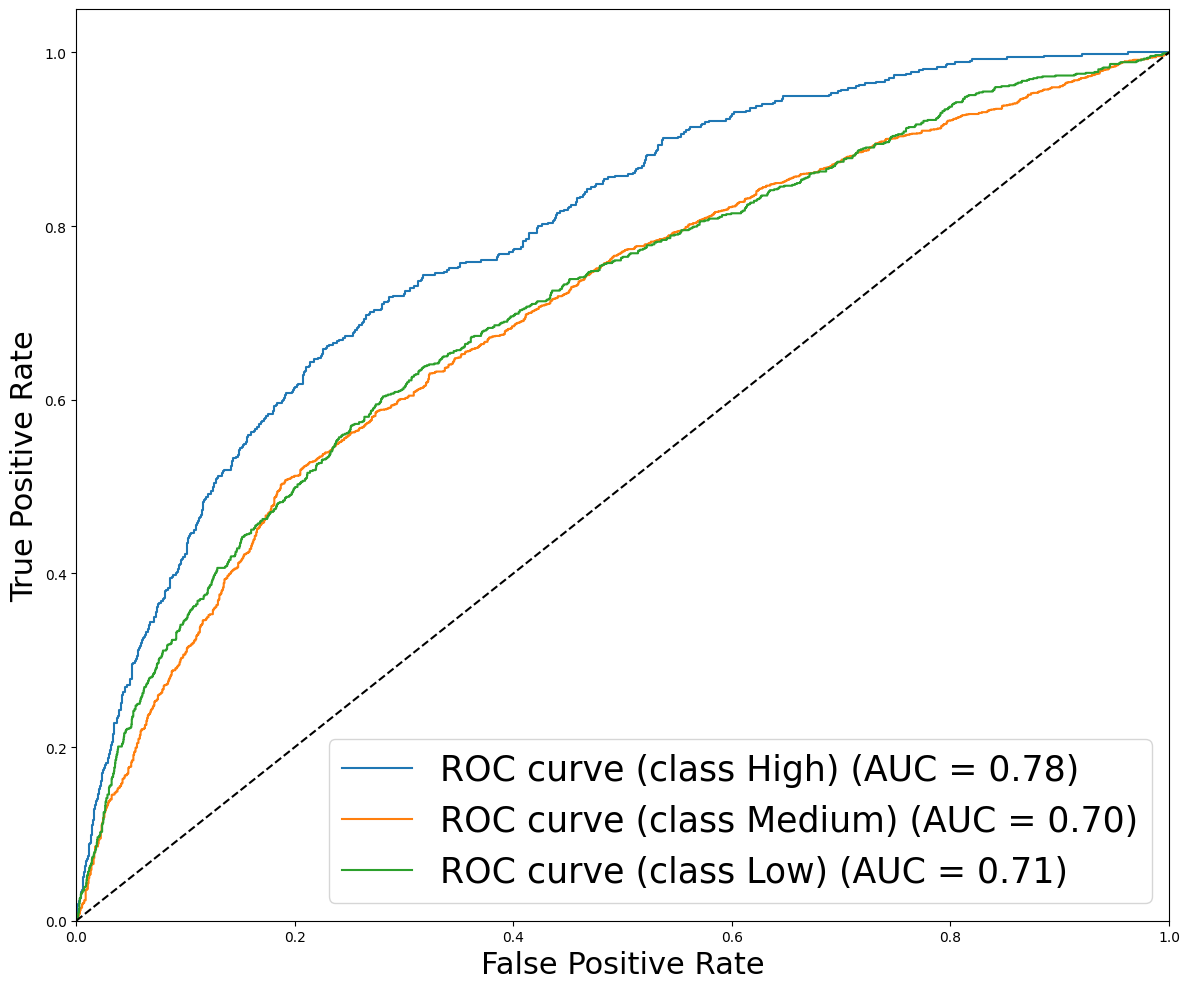

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=123)
X_train, X_test, y_train, y_test = train_test_split(esm_emb, test_data_labels, test_size=0.33, random_state=42)
clf.fit(X_train, y_train)
pred_class = clf.predict(X_test)
#confusion_matrix(y_test, pred_class)
report_bind_class_esm = classification_report(y_test, pred_class, digits=4)
print(report_bind_class_esm)


from sklearn.metrics import roc_curve, auc
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(clf.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test == clf.classes_[i], clf.predict_proba(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(12,10))
cls_lables =['High', 'Medium', 'Low']
for i in range(len(clf.classes_)):
    plt.plot(fpr[i], tpr[i], label='ROC curve (class {}) (AUC = {:.2f})'.format(cls_lables[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=22)
plt.ylabel('True Positive Rate', fontsize=22)
#plt.title('ROC curve for predicting binding affinity class\n(ESM-2 Model Embedding)', fontsize=18)
plt.legend(loc="lower right", fontsize=25)
plt.tight_layout() 
plt.savefig('plots/classification_1_esm2.png')
plt.show()

#### Ab-Affinity

/home/fashr003/anaconda3/envs/fbagpuenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           1     0.6659    0.5178    0.5825       535
           2     0.6943    0.8590    0.7679      2340
           3     0.5915    0.3275    0.4216       977

    accuracy                         0.6768      3852
   macro avg     0.6506    0.5681    0.5907      3852
weighted avg     0.6643    0.6768    0.6543      3852



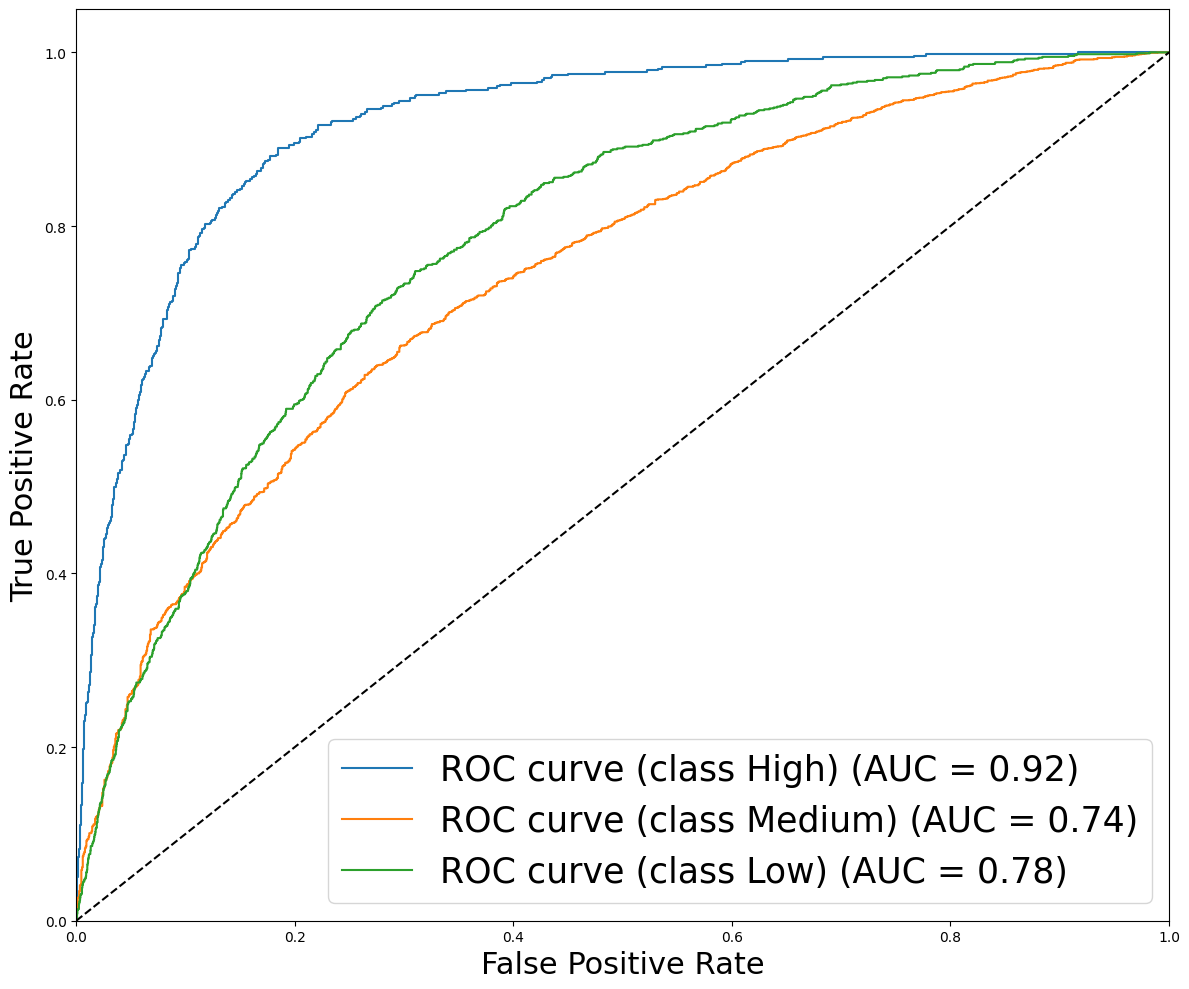

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=123)
X_train, X_test, y_train, y_test = train_test_split(model_emb, test_data_labels, test_size=0.33, random_state=42)
clf.fit(X_train, y_train)
pred_class = clf.predict(X_test)
#confusion_matrix(y_test, pred_class)
report_bind_class_model = classification_report(y_test, pred_class, digits=4)
print(report_bind_class_model)


from sklearn.metrics import roc_curve, auc
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(clf.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test == clf.classes_[i], clf.predict_proba(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(12,10))
cls_lables =['High', 'Medium', 'Low']
for i in range(len(clf.classes_)):
    plt.plot(fpr[i], tpr[i], label='ROC curve (class {}) (AUC = {:.2f})'.format(cls_lables[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=22)
plt.ylabel('True Positive Rate', fontsize=22)
#plt.title('ROC curve for predicting binding affinity class\n(Ab-Affinity Model Embedding)', fontsize=18)
plt.legend(loc="lower right", fontsize=25)
plt.tight_layout() 
plt.savefig('plots/classification_1_abaffinity.png')
plt.show()

## Improve Binding Class Prediction

In [ ]:
test_data_labels_2 = df['improve_binding'].tolist() 

#### ESM-2

/home/fashr003/anaconda3/envs/fbagpuenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/fashr003/anaconda3/envs/fbagpuenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/fashr003/anaconda3/envs/fbagpuenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

              precision    recall  f1-score   support

     class 0     0.9400    1.0000    0.9691      3621
     class 1     0.0000    0.0000    0.0000       231

    accuracy                         0.9400      3852
   macro avg     0.4700    0.5000    0.4845      3852
weighted avg     0.8837    0.9400    0.9110      3852



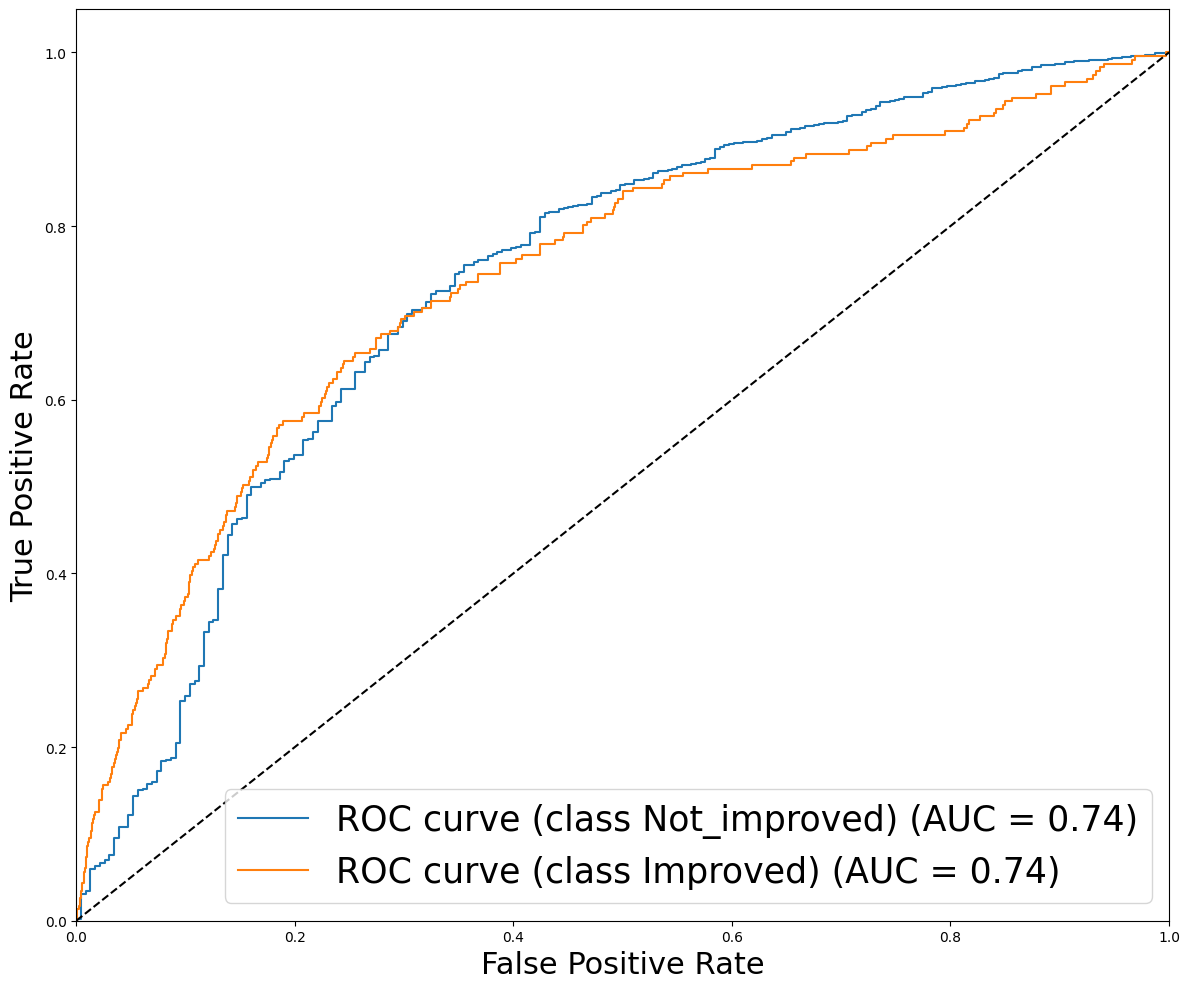

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

clf2 = LogisticRegression(random_state=123)
X_train, X_test, y_train, y_test = train_test_split(esm_emb, test_data_labels_2, test_size=0.33, random_state=42)
clf2.fit(X_train, y_train)
pred_class = clf2.predict(X_test)
#confusion_matrix(y_test, pred_class)
target_names = ['class 0', 'class 1']
report_improve_esm = classification_report(y_test, pred_class, target_names=target_names, digits=4)
print(report_improve_esm) 


from sklearn.metrics import roc_curve, auc
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(clf2.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test == clf2.classes_[i], clf2.predict_proba(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(12,10))
cls_lables =['Not_improved', 'Improved']
for i in range(len(clf2.classes_)):
    plt.plot(fpr[i], tpr[i], label='ROC curve (class {}) (AUC = {:.2f})'.format(cls_lables[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=22)
plt.ylabel('True Positive Rate', fontsize=22)
#plt.title('ROC curve for predicting improve_binding class\n(ESM-2 Model Embedding)', fontsize=18)
plt.legend(loc="lower right", fontsize=25)
plt.tight_layout()
plt.savefig('plots/classification_2_esm2.png')
plt.show()


#### Ab-Affinity

              precision    recall  f1-score   support

           0     0.9595    0.9881    0.9736      3621
           1     0.6504    0.3463    0.4520       231

    accuracy                         0.9496      3852
   macro avg     0.8050    0.6672    0.7128      3852
weighted avg     0.9410    0.9496    0.9423      3852



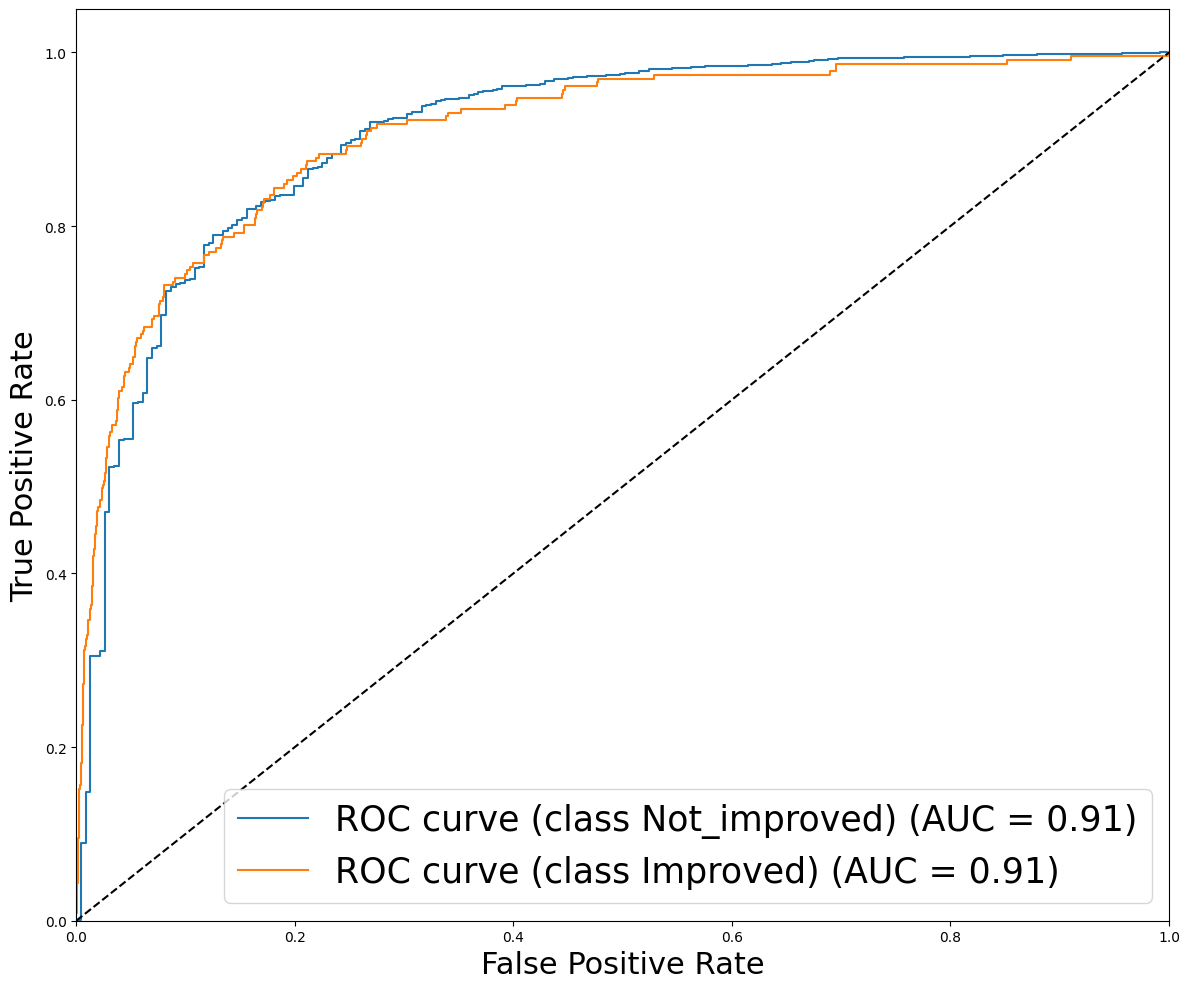

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

clf3 = LogisticRegression(random_state=123)
X_train, X_test, y_train, y_test = train_test_split(model_emb, test_data_labels_2, test_size=0.33, random_state=42)
clf3.fit(X_train, y_train)
pred_class = clf3.predict(X_test)
#confusion_matrix(y_test, pred_class)
report_improve_model = classification_report(y_test, pred_class, digits=4)
print(report_improve_model)


from sklearn.metrics import roc_curve, auc
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(clf3.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test == clf3.classes_[i], clf3.predict_proba(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Plot ROC curve for each class
plt.figure(figsize=(12,10))
cls_lables =['Not_improved', 'Improved']
for i in range(len(clf3.classes_)):
    plt.plot(fpr[i], tpr[i], label='ROC curve (class {}) (AUC = {:.2f})'.format(cls_lables[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=22)
plt.ylabel('True Positive Rate', fontsize=22)
#plt.title('ROC curve for predicting improve_binding class\n(ESM-2 Model Embedding)', fontsize=18)
plt.legend(loc="lower right", fontsize=25)
plt.tight_layout()
plt.savefig('plots/classification_2_abaffinity.png')
plt.show()

